In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tst_model import TST

In [2]:
# USDCHFM5.csv ['DateTime','Open', 'High', 'Low', 'Close', 'Volume', 'Extra'] , USDCHF1440.csv ['DateTime','Time' ,'Open', 'High', 'Low', 'Close', 'Volume', 'Extra']
colnames = ['DateTime','Open', 'High', 'Low', 'Close', 'Volume', 'Extra']

In [3]:
# USDCHFM5.csv use UTF 16 encoding Format USDCHF1440.csv use UTF 8 encoding format
df = pd.read_csv(
    'USDCHFM5.csv',
    encoding='utf-16',
    header=None,
    names=colnames
)

In [4]:

# Konversi kolom DateTime ke tipe datetime, lalu jadikan index
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y.%m.%d %H:%M')
df.set_index('DateTime', inplace=True)

# Print bossku
print(df.head())
print(df.dtypes)

                        Open     High      Low    Close  Volume  Extra
DateTime                                                              
2022-07-12 09:15:00  0.98360  0.98430  0.98358  0.98407     473      0
2022-07-12 09:20:00  0.98408  0.98427  0.98359  0.98390     462      0
2022-07-12 09:25:00  0.98389  0.98422  0.98355  0.98412     454      0
2022-07-12 09:30:00  0.98413  0.98451  0.98363  0.98390     581      0
2022-07-12 09:35:00  0.98390  0.98428  0.98370  0.98423     540      0
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Extra       int64
dtype: object


In [5]:
# Jika ingin hanya mengambil kolom OHLC, bisa tambahkan volume dkk
ohlc = df[['Open','High','Low','Close']]
print(ohlc.head())

                        Open     High      Low    Close
DateTime                                               
2022-07-12 09:15:00  0.98360  0.98430  0.98358  0.98407
2022-07-12 09:20:00  0.98408  0.98427  0.98359  0.98390
2022-07-12 09:25:00  0.98389  0.98422  0.98355  0.98412
2022-07-12 09:30:00  0.98413  0.98451  0.98363  0.98390
2022-07-12 09:35:00  0.98390  0.98428  0.98370  0.98423


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
ohlc_scaled = scaler.fit_transform(ohlc)
print("Contoh hasil normalisasi:", ohlc_scaled[:3])

# ⬇️ Simpan scaler ke file
joblib.dump(scaler, "scalerTST.save")
print("Scaler saved to 'scaler.save'")

Contoh hasil normalisasi: [[0.80523968 0.80857609 0.80841416 0.8081925 ]
 [0.80825532 0.80838774 0.80847714 0.80712446]
 [0.80706163 0.80807383 0.80822522 0.80850663]]
Scaler saved to 'scaler.save'


In [7]:
def create_multistep_dataset(data, window_size=12, steps_ahead=5):
    X, y = [], []
    for i in range(len(data) - window_size - steps_ahead):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + steps_ahead])
    return np.array(X), np.array(y)

In [8]:
window_size = 12     # 1 jam (jika data pakai dataset usdchfm5)
steps_ahead = 5      # prediksi 5 bar ke depan 5x5menit = 25 menit

In [9]:
X, y = create_multistep_dataset(ohlc_scaled, window_size, steps_ahead)
print("X shape:", X.shape)  # (samples, 12, 4) 12 timestep dengan 4 fitur dataset OHLC gacor
print("y shape:", y.shape)  # (samples, 5, 4) 5 timestep prediksi ahead dengan4 fitur dataset OHLC gacor

X shape: (99998, 12, 4)
y shape: (99998, 5, 4)


In [10]:
# Split train-test tanpa shuffle (biar tetap urutan waktu)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

X_train shape: (79998, 12, 4)
y_train shape: (79998, 5, 4)
X_test shape : (20000, 12, 4)
y_test shape : (20000, 5, 4)


In [12]:


class OHLCMultiStepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = OHLCMultiStepDataset(X_train, y_train)
test_dataset = OHLCMultiStepDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [13]:
# Ambil satu batch dari train_loader
for X_batch, y_batch in train_loader:
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    print("Contoh X_batch[0]:\n", X_batch[0])
    print("Contoh y_batch[0]:\n", y_batch[0])
    break  # supaya hanya print 1 batch


X_batch shape: torch.Size([64, 12, 4])
y_batch shape: torch.Size([64, 5, 4])
Contoh X_batch[0]:
 tensor([[0.2324, 0.2323, 0.2342, 0.2326],
        [0.2326, 0.2320, 0.2343, 0.2327],
        [0.2328, 0.2325, 0.2347, 0.2330],
        [0.2331, 0.2324, 0.2342, 0.2323],
        [0.2323, 0.2317, 0.2338, 0.2323],
        [0.2323, 0.2318, 0.2333, 0.2315],
        [0.2315, 0.2313, 0.2334, 0.2320],
        [0.2320, 0.2317, 0.2338, 0.2320],
        [0.2320, 0.2314, 0.2322, 0.2316],
        [0.2316, 0.2318, 0.2333, 0.2321],
        [0.2323, 0.2336, 0.2342, 0.2335],
        [0.2335, 0.2332, 0.2341, 0.2331]])
Contoh y_batch[0]:
 tensor([[0.2330, 0.2328, 0.2341, 0.2322],
        [0.2323, 0.2319, 0.2337, 0.2319],
        [0.2318, 0.2312, 0.2325, 0.2306],
        [0.2306, 0.2300, 0.2316, 0.2299],
        [0.2299, 0.2302, 0.2304, 0.2295]])


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TST(c_in=4, c_out=5*4, seq_len=12).to(device)  # pastikan output 20
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(model)

# TST(
#     c_in=4,
#     c_out=5*4,
#     seq_len=12,
#     d_model=128,           # Dimensi embedding / representasi
#     n_heads=8,             # Jumlah attention head
#     d_k=16, d_v=16,        # Dimensi masing-masing head (opsional)
#     n_layers=3,            # Jumlah encoder layer
#     d_ff=256,              # Ukuran hidden layer pada feedforward
#     dropout=0.1,           # Dropout seluruh network
#     fc_dropout=0.0,        # Dropout pada final dense layer
#     act="gelu",            # Fungsi aktivasi (bisa diganti 'relu')
#     y_range=None,          # Bisa pakai range sigmoid output (contoh: (0,1))
# )


TST(
  (W_P): Linear(in_features=4, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (encoder): _TSTEncoder(
    (layers): ModuleList(
      (0-2): 3 x _TSTEncoderLayer(
        (self_attn): _MultiHeadAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=False)
          (W_K): Linear(in_features=128, out_features=128, bias=False)
          (W_V): Linear(in_features=128, out_features=128, bias=False)
          (W_O): Linear(in_features=128, out_features=128, bias=False)
          (attention): _ScaledDotProductAttention()
        )
        (dropout_attn): Dropout(p=0.1, inplace=False)
        (batchnorm_attn): Sequential(
          (0): Transpose()
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Transpose()
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, i

In [15]:
# Model
model = TST(c_in=4, c_out=5*4, seq_len=12).to(device)


In [16]:
# Loss dan optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [17]:
# Config manual
epochs = 10
verbose = True

# Tracking loss
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device).permute(0, 2, 1)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch).view(-1, 5, 4)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device).permute(0, 2, 1)
            y_batch = y_batch.to(device)

            output = model(X_batch).view(-1, 5, 4)
            val_loss = criterion(output, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    if verbose:
        print(f"Epoch {epoch:02d}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")


Epoch 01/10 - Train Loss: 0.006014 - Val Loss: 0.000356
Epoch 02/10 - Train Loss: 0.002289 - Val Loss: 0.002264
Epoch 03/10 - Train Loss: 0.001886 - Val Loss: 0.000903
Epoch 04/10 - Train Loss: 0.001625 - Val Loss: 0.000752
Epoch 05/10 - Train Loss: 0.001592 - Val Loss: 0.000251
Epoch 06/10 - Train Loss: 0.001454 - Val Loss: 0.001954
Epoch 07/10 - Train Loss: 0.001837 - Val Loss: 0.003895
Epoch 08/10 - Train Loss: 0.001640 - Val Loss: 0.000072
Epoch 09/10 - Train Loss: 0.001370 - Val Loss: 0.000675
Epoch 10/10 - Train Loss: 0.001393 - Val Loss: 0.000129


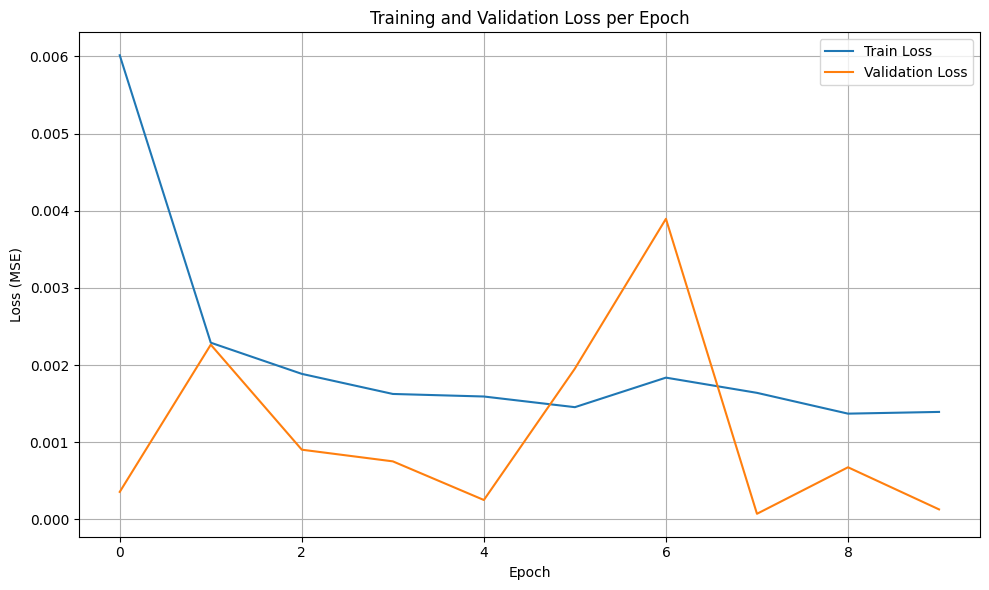

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
#Mclarenlu warna apa bos?
torch.save(model.state_dict(), "tst_ohlc_model.pt")
print("Model saved to 'tst_ohlc_model.pt'")


Model saved to 'tst_ohlc_model.pt'


In [20]:
# Ambil satu sample dari test set
sample_input = X_test[0]  # shape: (12, 4)
sample_input = torch.tensor(sample_input, dtype=torch.float32).unsqueeze(0)  # (1, 12, 4)
sample_input = sample_input.permute(0, 2, 1).to(device)  # jadi (1, 4, 12)

# Load model dan jalankan prediksi
model.eval()
with torch.no_grad():
    output = model(sample_input).view(-1, 5, 4).cpu().numpy()  # (1, 5, 4) → (5, 4)

# Tampilkan hasil prediksi
print("Hasil prediksi 5 langkah ke depan (Open, High, Low, Close):")
print(output[0])  # prediksi untuk langkah ke-1
print(output)     # semua 5 langkah

Hasil prediksi 5 langkah ke depan (Open, High, Low, Close):
[[0.10835945 0.10752296 0.10871351 0.10691555]
 [0.10686657 0.10785483 0.10721529 0.10685772]
 [0.10772426 0.1077548  0.10771244 0.10628616]
 [0.10623041 0.10671374 0.1073789  0.10591806]
 [0.10532973 0.10670079 0.10693719 0.10655707]]
[[[0.10835945 0.10752296 0.10871351 0.10691555]
  [0.10686657 0.10785483 0.10721529 0.10685772]
  [0.10772426 0.1077548  0.10771244 0.10628616]
  [0.10623041 0.10671374 0.1073789  0.10591806]
  [0.10532973 0.10670079 0.10693719 0.10655707]]]
